In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
#plt.style.use('ggplot')
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

np.random.seed(1234)
import pymc3 as pm
import scipy.stats as stats

import logging
_logger = logging.getLogger("theano.gof.compilelock")
_logger.setLevel(logging.ERROR)

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled)


In [2]:
# observed data
df = pd.read_csv('data/HtWt.csv')
df.head()

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6


In [3]:
niter = 1000
with pm.Model() as model:
    pm.glm.glm('male ~ height + weight', df, family=pm.glm.families.Binomial())
    trace = pm.sample(niter, step=pm.Slice(), random_seed=123, progressbar=True)

 [-----------------100%-----------------] 1000 of 1000 complete in 2.0 sec

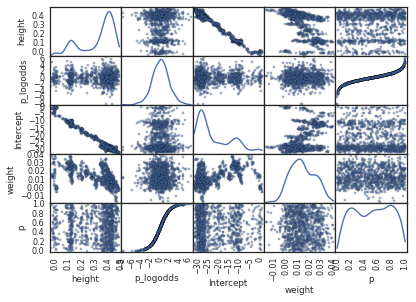

In [4]:
# note that height and weigth in trace refer to the coefficients

df_trace = pm.trace_to_dataframe(trace)
pd.scatter_matrix(df_trace[-1000:], diagonal='kde');

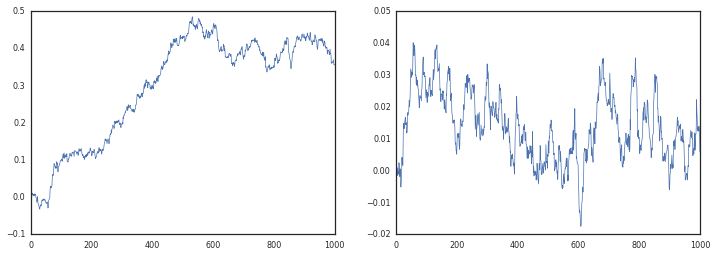

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(df_trace.ix[-1000:, 'height'], linewidth=0.7)
plt.subplot(122)
plt.plot(df_trace.ix[-1000:, 'weight'], linewidth=0.7);

In [6]:
pm.summary(trace);


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -21.801          8.857            0.884            [-31.854, -3.726]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -31.239        -28.848        -26.617        -13.757        -0.390


height:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.296            0.145            0.014            [-0.009, 0.466]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.011         0.150          0.362          0.416          0.465


weight:

  Mean             SD               MC Error         95% HPD interval
  --------------

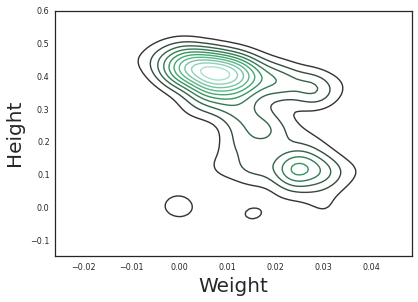

In [7]:
#import seaborn as sn
sns.kdeplot(trace['weight'], trace['height'])
plt.xlabel('Weight', fontsize=20)
plt.ylabel('Height', fontsize=20)

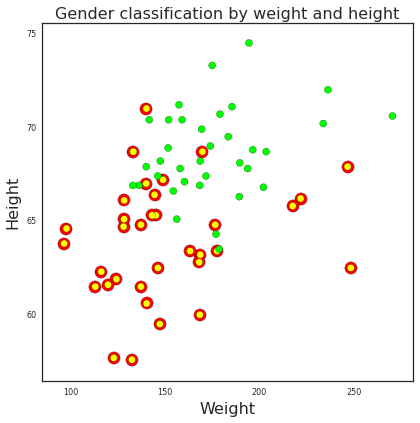

In [8]:
intercept, height, p, p_logodds, weight = df_trace[-niter//2:].mean(0)

def predict(w, h, height=height, weight=weight):
    """Predict gender given weight (w) and height (h) values."""
    v = intercept + height*h + weight*w
    return np.exp(v)/(1+np.exp(v))

# calculate predictions on grid
xs = np.linspace(df.weight.min(), df.weight.max(), 100)
ys = np.linspace(df.height.min(), df.height.max(), 100)
X, Y = np.meshgrid(xs, ys)
Z = predict(X, Y)

plt.figure(figsize=(6,6))

# plot 0.5 contour line - classify as male if above this line
plt.contour(X, Y, Z, levels=[0.5])

# classify all subjects
colors = ['lime' if i else 'yellow' for i in df.male]
ps = predict(df.weight, df.height)
errs = ((ps < 0.5) & df.male) |((ps >= 0.5) & (1-df.male))
plt.scatter(df.weight[errs], df.height[errs], facecolors='red', s=150)
plt.scatter(df.weight, df.height, facecolors=colors, edgecolors='k', s=50, alpha=1);
plt.xlabel('Weight', fontsize=16)
plt.ylabel('Height', fontsize=16)
plt.title('Gender classification by weight and height', fontsize=16)
plt.tight_layout();